# 时间序列

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller     # 平稳性检验
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARMA
import warnings
from pywt import wavedec,waverec
warnings.filterwarnings("ignore")

## 函数

In [2]:
# 平稳性检验
def adfTest(data):
    dftest = adfuller(data)
    if dftest[1] < 0.001:
        return True
    else:
        return False

In [3]:
# ACF和PACF
def acf_pacf_Test(data,n):
    acf,q,p = sm.tsa.acf(data,nlags=n,qstat=True)
    pacf = sm.tsa.acf(data,nlags=n)
    out = np.c_[range(1,n+1), acf[1:], pacf[1:], q, p]
    output=pd.DataFrame(out, columns=['lag', "AC", "PAC", "Q", "P-value"])
    return output

In [4]:
# 返回各回归评估参数值MSE,RMSE,MAE,R2
def evaluationValue(data_true,data_predict):
    mse = np.sum((data_predict-data_true)**2) / len(data_true)
    rmse = np.sqrt(mse)
    mae = np.sum(np.absolute(data_predict-data_true)) / len(data_true)
    r2 = 1- mse / np.var(data_true)
    out = np.c_[1, mse, rmse, mae, r2]
    output=pd.DataFrame(out, columns=['index', "MSE", "RMSE", "MAE", "R2"])
    return output

In [5]:
# 差分处理,默认最大为5阶
def bestDiff(df, maxdiff = 6):
    temp = df.copy()
    first_values = []
    for i in range(0, maxdiff):
        if i == 0:
            temp['diff'] = temp[temp.columns[0]]
        else:
            first_values.append(pd.Series([temp['diff'][1]],index=[temp['diff'].index[0]]))
            temp['diff'] = temp['diff'].diff(1)
            temp = temp.dropna() #差分后，前几行的数据会变成nan，所以删掉
            # print(temp['diff'],'\n')
        if adfTest(temp['diff']):
            bestdiff = i
            return temp['diff'],first_values
        else:
            continue
    return temp['diff'],first_values

In [6]:
# 差分恢复
def recoverDiff(df_diff,first_values):
    df_restored = df_diff
    for first in reversed(first_values):
        df_restored = first.append(df_restored).cumsum()
    return df_restored

In [7]:
# HP分解
def hpFilter(data,l=1600):
    cycles, trend = sm.tsa.filters.hpfilter(data,l)
    return cycles,trend

In [8]:
# DW检验
def evaluationDW(resid):
    return sm.stats.durbin_watson(resid)

In [9]:
# 小波分解
def waveletFilter(data,level,func='db4'):
    coeffs = wavedec(data, func, level=level)
    return coeffs

In [10]:
# 小波恢复
def recoverWavelet(coeffs,func='db4'):
    data = waverec(coeffs, func)
    return data

In [11]:
# 模型评估,滚动预测
def evaluationModle(data,order,train_size=-1):
    if train_size == -1:    
        train_size = int(len(data) * 0.66)
    train, test = data[0:train_size], data[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARMA(history, order=order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat[0])
        history.append(test[t])
    error = evaluationValue(test, predictions)
    # print(predictions)
    sns.lineplot(np.array(list(range(len(predictions)))),np.array(predictions),color='r')
    sns.lineplot(np.array(list(range(len(test)))),test,color='b')
    plt.show()
    return error,predictions

In [12]:
# 模型PQ选择，方法1（使用评估参数）
def chooseModels1(data, maxlag=5,method='MSE'):
    best_score, best_cfg = float("inf"), None
    for p in np.arange(maxlag):
        for q in np.arange(maxlag):
            order = (p,q)
            try:
                error,predictions = evaluationModle(data, order)
                print(order, error[method].values)
                if error[method].values < best_score:
                    best_score, best_cfg = error[method].values, order
            except:
                print(order,'error')
                continue
    return best_score,best_cfg

In [13]:
# 模型PQ选择，方法2（使用aic,bic,hqic）
def chooseModels2(data, maxlag=5,method='aic'):
    best_score, best_cfg = float("inf"), None
    for p in np.arange(maxlag):
        for q in np.arange(maxlag):
            order = (p,q)
            model = ARMA(data, order=order)
            try:
                results_ARMA = model.fit(disp=0)
                if method == 'aic':
                    score = results_ARMA.aic
                elif method == 'bic':
                    score = results_ARMA.bic
                elif method == 'hqic':
                    score = results_ARMA.hqic
                print(order, score)
                if score < best_score:
                    best_score, best_cfg = score, order
            except:
                print(order, 'error')
                continue
    return best_score,best_cfg

In [14]:
# 模型拟合
def fitModel(data,order):
    model = ARMA(data,order=order)
    model_result = model.fit(disp=0)
    return model,model_result

In [15]:
# 模型检验
def modelBLQ(model_result,n):
    output = acf_pacf_Test(model_result.resid,n)['P-value']
    for i in range(len(output)):
        if output[i] < 0.05:
            return False
        return True

In [16]:
# 向内模型预测
def forcastInModel(model_result):
    train_predict = model_result.predict()
    return train_predict

In [17]:
# 向外模型预测
def forcastOutModel(model_result,step):
    train_predict,b,train_predict_conf_int = model_result.forecast(step)
    return train_predict,train_predict_conf_int

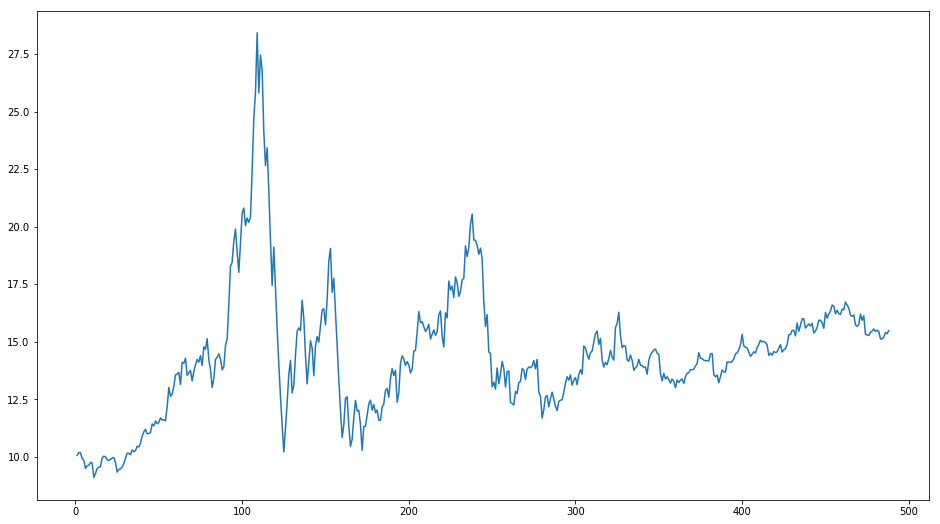

In [18]:
dicstock102419={"1":"10.07","2":"10.2","3":"10.19","4":"9.94","5":"9.85","6":"9.51","7":"9.62","8":"9.65","9":"9.77","10":"9.73","11":"9.11","12":"9.29","13":"9.5","14":"9.56","15":"9.58","16":"9.96","17":"10.04","18":"10.01","19":"9.88","20":"9.85","21":"9.9","22":"9.96","23":"9.98","24":"9.76","25":"9.35","26":"9.47","27":"9.48","28":"9.57","29":"9.72","30":"9.94","31":"10.17","32":"10.16","33":"10.1","34":"10.31","35":"10.23","36":"10.28","37":"10.47","38":"10.44","39":"10.6","40":"10.91","41":"11.09","42":"11.21","43":"11.01","44":"11.02","45":"11.06","46":"11.44","47":"11.35","48":"11.57","49":"11.45","50":"11.5","51":"11.7","52":"11.61","53":"11.62","54":"11.58","55":"12.18","56":"13.02","57":"12.64","58":"12.73","59":"13.07","60":"13.57","61":"13.6","62":"13.68","63":"13.15","64":"14.11","65":"14.07","66":"14.29","67":"13.55","68":"13.66","69":"13.76","70":"13.31","71":"13.71","72":"14.0","73":"14.24","74":"14.12","75":"14.4","76":"13.98","77":"14.79","78":"14.68","79":"15.14","80":"14.23","81":"13.8","82":"13.02","83":"13.4","84":"14.24","85":"14.33","86":"14.48","87":"14.25","88":"13.79","89":"13.92","90":"14.84","91":"15.12","92":"16.63","93":"18.29","94":"18.46","95":"19.38","96":"19.9","97":"18.92","98":"18.02","99":"19.27","100":"20.58","101":"20.81","102":"20.05","103":"20.38","104":"20.19","105":"20.42","106":"22.46","107":"24.71","108":"25.84","109":"28.42","110":"25.81","111":"27.46","112":"26.8","113":"24.12","114":"22.66","115":"23.43","116":"21.54","117":"19.39","118":"17.45","119":"19.12","120":"17.31","121":"15.58","122":"14.02","123":"12.62","124":"11.36","125":"10.22","126":"11.24","127":"12.36","128":"13.6","129":"14.2","130":"12.78","131":"13.11","132":"14.42","133":"15.46","134":"15.61","135":"15.49","136":"16.81","137":"16.02","138":"14.42","139":"13.18","140":"14.11","141":"15.05","142":"14.73","143":"13.53","144":"14.82","145":"15.23","146":"14.99","147":"15.69","148":"16.39","149":"16.44","150":"15.74","151":"16.84","152":"18.52","153":"19.06","154":"17.15","155":"17.76","156":"16.3","157":"14.85","158":"13.37","159":"12.03","160":"10.85","161":"11.4","162":"12.54","163":"12.62","164":"11.36","165":"10.46","166":"10.78","167":"11.72","168":"12.46","169":"12.0","170":"12.03","171":"11.41","172":"10.29","173":"11.32","174":"11.34","175":"11.83","176":"12.31","177":"12.47","178":"12.04","179":"12.28","180":"11.92","181":"12.04","182":"11.6","183":"11.6","184":"12.16","185":"12.31","186":"12.89","187":"12.98","188":"12.6","189":"13.41","190":"13.84","191":"13.54","192":"13.76","193":"12.38","194":"12.78","195":"14.06","196":"14.4","197":"14.26","198":"13.98","199":"14.14","200":"14.01","201":"13.65","202":"13.82","203":"14.6","204":"14.63","205":"15.42","206":"16.32","207":"15.83","208":"15.88","209":"15.67","210":"15.45","211":"15.57","212":"15.76","213":"15.12","214":"15.33","215":"15.52","216":"15.29","217":"15.43","218":"16.2","219":"16.34","220":"15.25","221":"14.78","222":"16.26","223":"16.04","224":"17.64","225":"17.25","226":"17.42","227":"16.93","228":"17.82","229":"17.57","230":"16.98","231":"17.19","232":"17.69","233":"17.76","234":"19.17","235":"18.7","236":"19.09","237":"20.1","238":"20.55","239":"19.43","240":"19.41","241":"19.2","242":"18.8","243":"19.07","244":"18.61","245":"16.75","246":"15.67","247":"16.18","248":"14.56","249":"14.5","250":"13.05","251":"13.25","252":"12.95","253":"13.87","254":"13.18","255":"13.6","256":"14.15","257":"13.85","258":"13.04","259":"13.7","260":"13.74","261":"12.37","262":"12.33","263":"12.26","264":"12.85","265":"12.76","266":"13.23","267":"13.28","268":"13.84","269":"13.78","270":"13.36","271":"13.82","272":"13.91","273":"13.88","274":"13.95","275":"14.19","276":"13.83","277":"14.24","278":"12.82","279":"12.65","280":"11.69","281":"12.06","282":"12.62","283":"12.67","284":"12.18","285":"12.54","286":"12.82","287":"12.52","288":"12.2","289":"12.02","290":"12.41","291":"12.47","292":"12.49","293":"12.81","294":"13.22","295":"13.49","296":"13.34","297":"13.57","298":"13.12","299":"13.34","300":"13.45","301":"13.14","302":"13.59","303":"13.79","304":"13.6","305":"14.82","306":"14.74","307":"14.45","308":"14.25","309":"14.53","310":"14.61","311":"14.98","312":"15.36","313":"15.47","314":"14.89","315":"15.15","316":"14.23","317":"13.91","318":"14.11","319":"14.01","320":"14.28","321":"14.63","322":"14.34","323":"14.21","324":"15.63","325":"15.8","326":"16.29","327":"15.29","328":"14.75","329":"14.84","330":"14.81","331":"14.22","332":"14.16","333":"14.43","334":"14.2","335":"13.77","336":"13.87","337":"13.97","338":"14.24","339":"13.99","340":"13.97","341":"13.89","342":"13.91","343":"13.6","344":"14.2","345":"14.45","346":"14.55","347":"14.64","348":"14.69","349":"14.51","350":"14.46","351":"13.62","352":"13.31","353":"13.63","354":"13.39","355":"13.49","356":"13.36","357":"13.21","358":"13.39","359":"13.28","360":"13.01","361":"13.35","362":"13.23","363":"13.34","364":"13.39","365":"13.2","366":"13.49","367":"13.64","368":"13.66","369":"13.8","370":"13.79","371":"13.81","372":"13.96","373":"14.06","374":"14.53","375":"14.29","376":"14.27","377":"14.21","378":"14.18","379":"14.19","380":"14.17","381":"14.48","382":"14.5","383":"13.58","384":"13.49","385":"13.56","386":"13.23","387":"13.49","388":"13.78","389":"13.7","390":"13.69","391":"14.13","392":"14.12","393":"14.12","394":"14.14","395":"14.27","396":"14.48","397":"14.52","398":"14.66","399":"14.87","400":"15.33","401":"14.83","402":"14.76","403":"14.74","404":"14.56","405":"14.37","406":"14.46","407":"14.57","408":"14.52","409":"14.75","410":"14.89","411":"15.07","412":"15.01","413":"15.02","414":"14.97","415":"14.87","416":"14.42","417":"14.51","418":"14.42","419":"14.58","420":"14.54","421":"14.57","422":"14.73","423":"14.88","424":"14.56","425":"14.65","426":"14.71","427":"14.88","428":"15.31","429":"15.32","430":"15.5","431":"15.5","432":"15.26","433":"15.82","434":"15.46","435":"15.72","436":"16.0","437":"16.0","438":"15.6","439":"15.69","440":"15.78","441":"15.69","442":"15.81","443":"15.39","444":"15.47","445":"15.63","446":"15.94","447":"15.94","448":"15.84","449":"15.59","450":"16.28","451":"16.03","452":"16.22","453":"16.34","454":"16.6","455":"16.55","456":"16.22","457":"16.37","458":"16.23","459":"16.19","460":"16.42","461":"16.39","462":"16.73","463":"16.6","464":"16.47","465":"16.16","466":"16.11","467":"16.17","468":"15.74","469":"15.68","470":"15.76","471":"16.2","472":"15.94","473":"16.13","474":"15.33","475":"15.3","476":"15.28","477":"15.41","478":"15.47","479":"15.56","480":"15.45","481":"15.51","482":"15.45","483":"15.13","484":"15.13","485":"15.21","486":"15.4","487":"15.36","488":"15.49"}
x = np.array(list(dicstock102419.keys()),dtype='float64')
y = np.array(list(dicstock102419.values()),dtype='float64')
data = pd.DataFrame(y,x)
plt.figure(figsize=(16,9))
sns.lineplot(x,y)

## 差分序列

In [19]:
adfTest(y)    #不平稳

False

In [21]:
datad,first_value = bestDiff(data)  #进行差分，差分阶数为 len(first_value)
len(first_value)

1

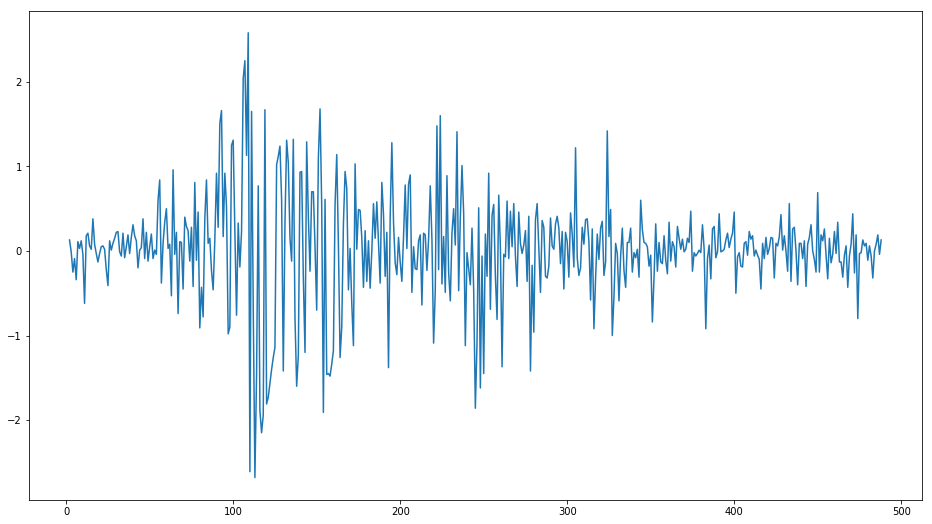

In [22]:
yd = datad.values
plt.figure(figsize=(16,9))
sns.lineplot(x[1:],yd)   #差分后图像

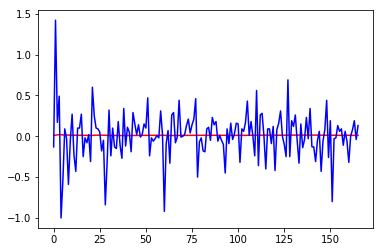

(0, 0) [0.08041686]


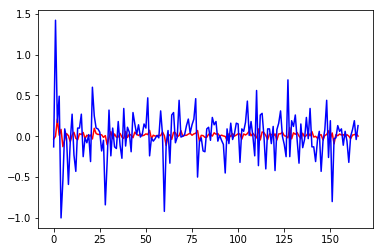

(0, 1) [0.08320272]


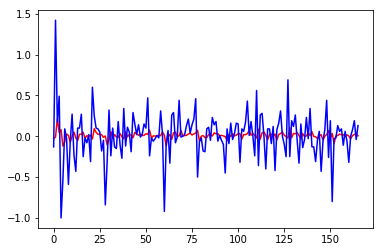

(0, 2) [0.08341979]


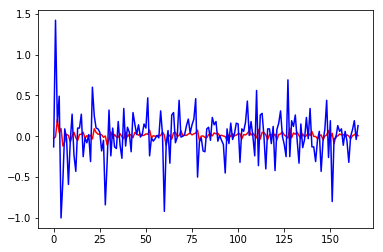

(0, 3) [0.08350787]


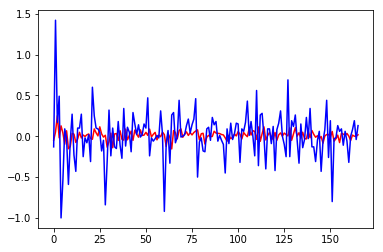

(0, 4) [0.08483243]


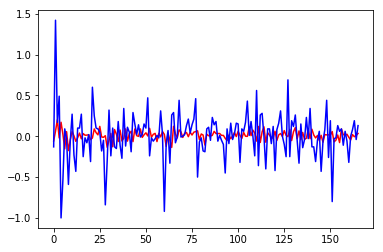

(0, 5) [0.08450419]


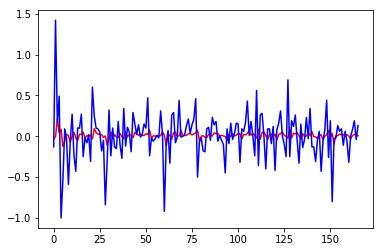

(1, 0) [0.08344131]


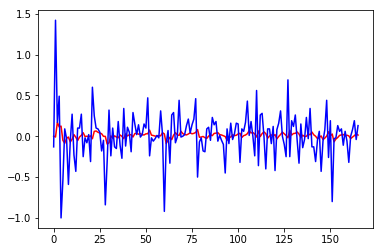

(1, 1) [0.0836965]
(1, 2) error
(1, 3) error
(1, 4) error
(1, 5) error


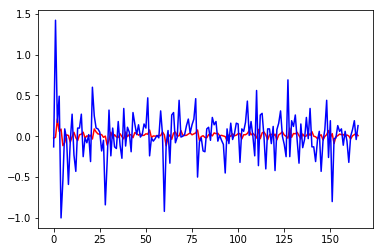

(2, 0) [0.08352119]


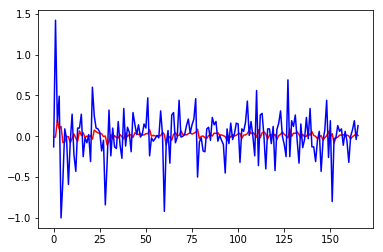

(2, 1) [0.08383703]


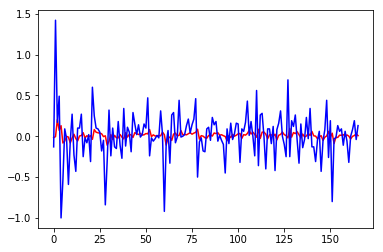

(2, 2) [0.08398973]
(2, 3) error
(2, 4) error
(2, 5) error


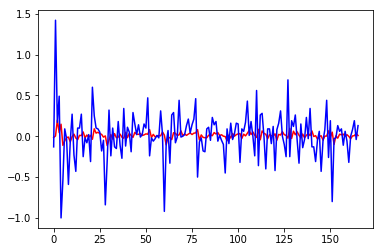

(3, 0) [0.08394737]


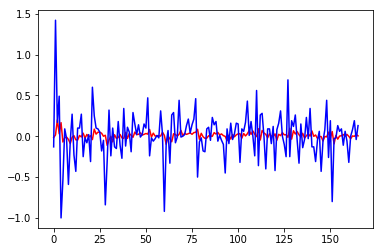

(3, 1) [0.08423015]


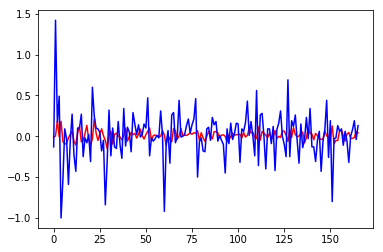

(3, 2) [0.08499342]
(3, 3) error
(3, 4) error
(3, 5) error


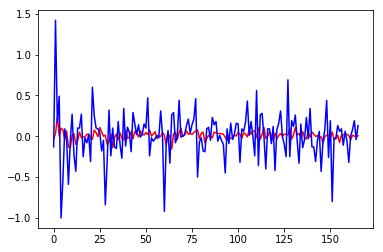

(4, 0) [0.08456955]


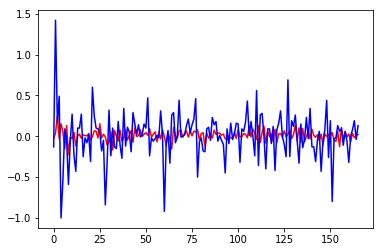

(4, 1) [0.08566541]


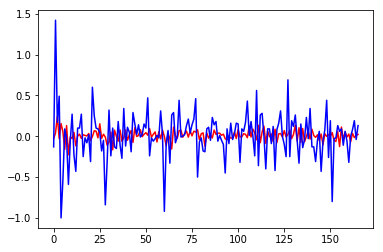

(4, 2) [0.085698]


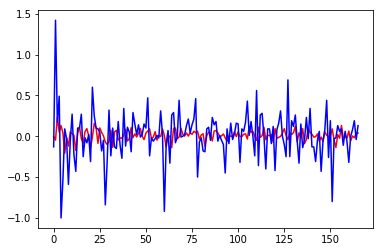

(4, 3) [0.08567986]


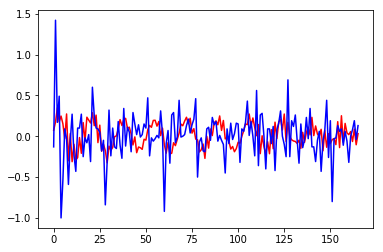

(4, 4) [0.09155374]
(4, 5) error


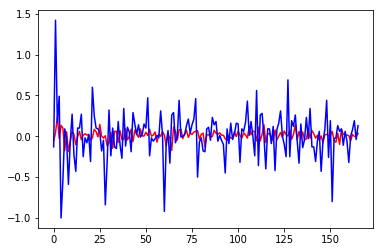

(5, 0) [0.08545094]


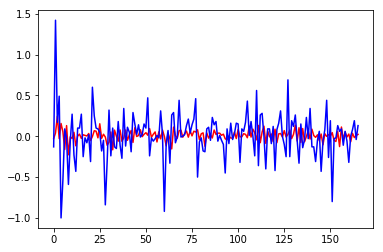

(5, 1) [0.08570125]
(5, 2) error


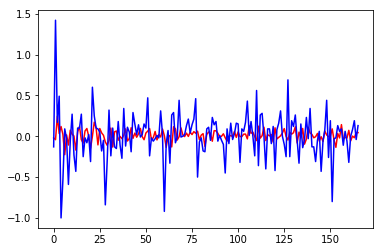

(5, 3) [0.08585186]


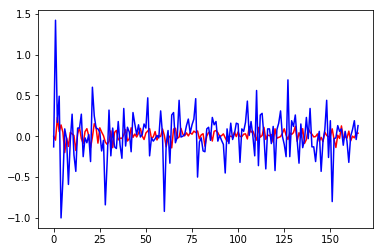

(5, 4) [0.08572857]
(5, 5) error


In [28]:
best_score,best_cfg = chooseModels1(yd, maxlag=6,method='MSE')

In [29]:
best_score

array([0.08041686])

In [30]:
best_cfg

(0, 0)

In [22]:
best_score,best_cfg = chooseModels2(yd,5,method='bic')

(0, 0) 959.1172353315972
(0, 1) 957.4859273902542
(0, 2) 963.3907405000673
(0, 3) 969.5482164608977
(0, 4) 966.5943516648819
(1, 0) 957.1715060389663
(1, 1) 962.5312668374183
(1, 2) error
(1, 3) error
(1, 4) error
(2, 0) 963.2562614753615
(2, 1) 968.2489674079883
(2, 2) 974.2159309226545
(2, 3) error
(2, 4) error
(3, 0) 968.8001429399731
(3, 1) 973.2781191573879
(3, 2) 972.4588922607925
(3, 3) error
(3, 4) error
(4, 0) 967.2983227765253
(4, 1) 967.8405427806711
(4, 2) 974.016051893648
(4, 3) 977.9998034021537
(4, 4) 969.5956516007942


In [23]:
best_score

957.1715060389663

In [24]:
best_cfg

(1, 0)

In [74]:
model, model_result = fitModel(yd,best_cfg)
mf = modelBLQ(model_result,10)
mf

True

In [26]:
yp = forcastInModel(model_result)

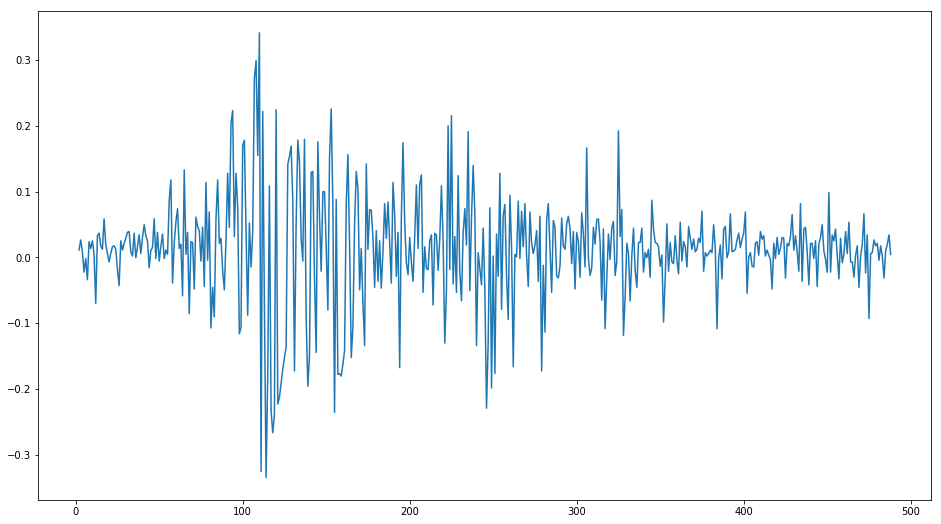

In [27]:
plt.figure(figsize=(16,9))
sns.lineplot(x[1:],yp)    # 预测后图像

In [28]:
df = pd.DataFrame(yp,index=list(range(len(first_value)+1,len(yp)+len(first_value)+1)))
ypr = recoverDiff(df, first_value)

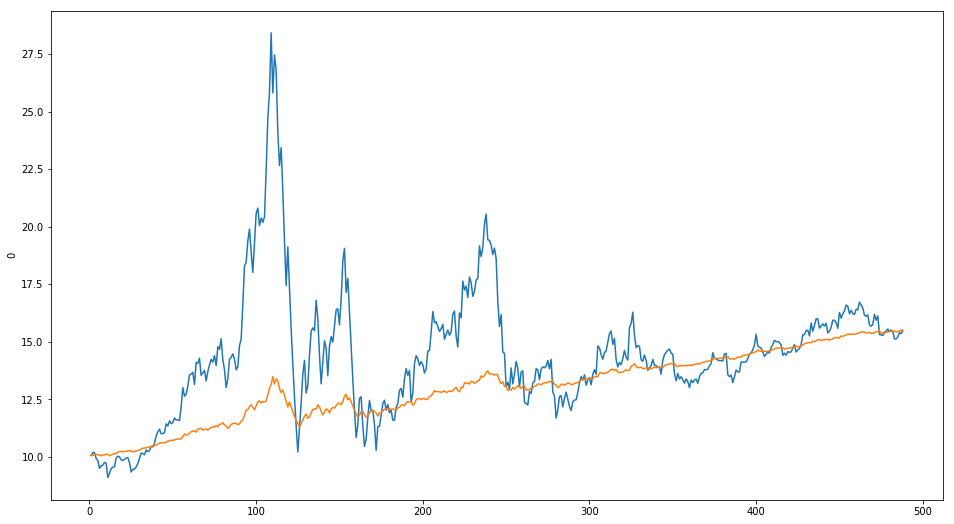

In [29]:
plt.figure(figsize=(16,9))
sns.lineplot(x,y)
sns.lineplot(x,ypr[0])

## HP滤波

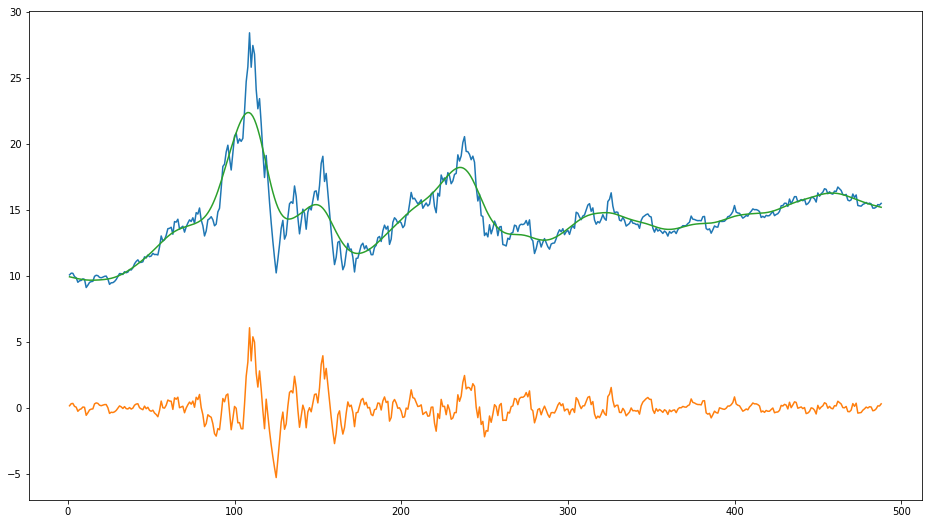

In [21]:
cycles,trend = hpFilter(y)    # 进行HP滤波分解
plt.figure(figsize=(16,9))
sns.lineplot(x,y)
sns.lineplot(x,cycles)
sns.lineplot(x,trend)
step = 100;

In [22]:
adfTest(cycles)

True

In [23]:
adfTest(trend)

False

In [24]:
td,tfv = bestDiff(pd.DataFrame(trend))

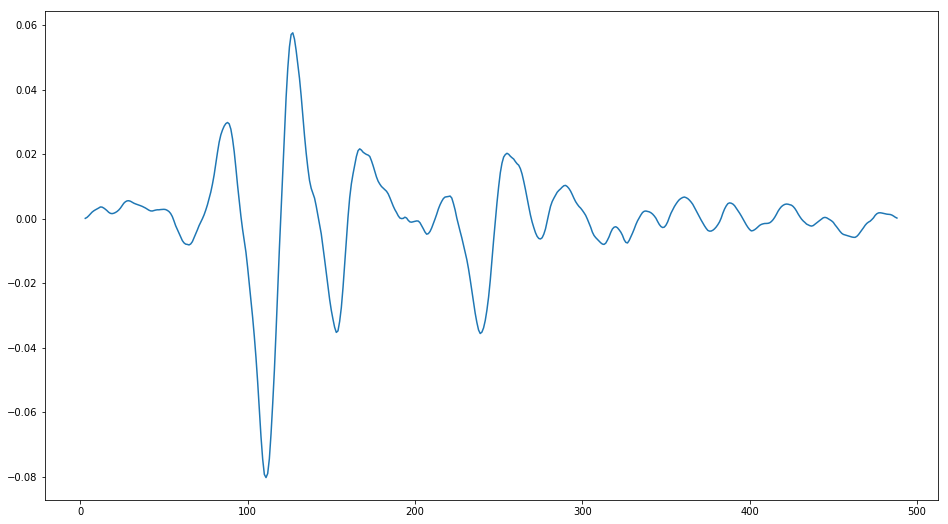

In [25]:
td = td.values
plt.figure(figsize=(16,9))
sns.lineplot(x[len(tfv):],td)

In [26]:
best_score,best_cfg = chooseModels2(td,5,method='bic')

(0, 0) -2598.043180875577
(0, 1) -3254.759511484198
(0, 2) error
(0, 3) error
(0, 4) error
(1, 0) -4366.111468724495
(1, 1) error
(1, 2) error
(1, 3) error
(1, 4) error
(2, 0) error
(2, 1) -6297.9330007461285
(2, 2) -6367.917773629811
(2, 3) -6367.76080941585
(2, 4) -6384.951528525135
(3, 0) error
(3, 1) -6389.767322626952
(3, 2) -6383.630828513481
(3, 3) -6377.769047619613
(3, 4) -6381.0497443139075
(4, 0) error
(4, 1) -6383.586663017474
(4, 2) -6383.510904787156
(4, 3) -6380.21594451777
(4, 4) -6378.893412652493


In [27]:
best_score,best_cfg

(-6389.767322626952, (3, 1))

True

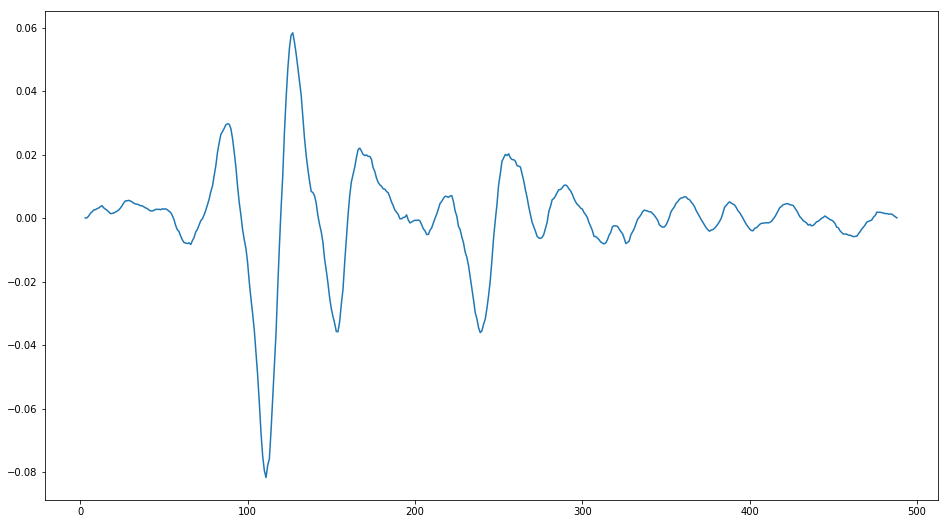

In [28]:
model, model_result = fitModel(td,best_cfg)
mf = modelBLQ(model_result,int(488*0.33))
tp = forcastInModel(model_result)
tpo,tpci = forcastOutModel(model_result,step)
plt.figure(figsize=(16,9))
sns.lineplot(x[len(tfv):],tp)
mf

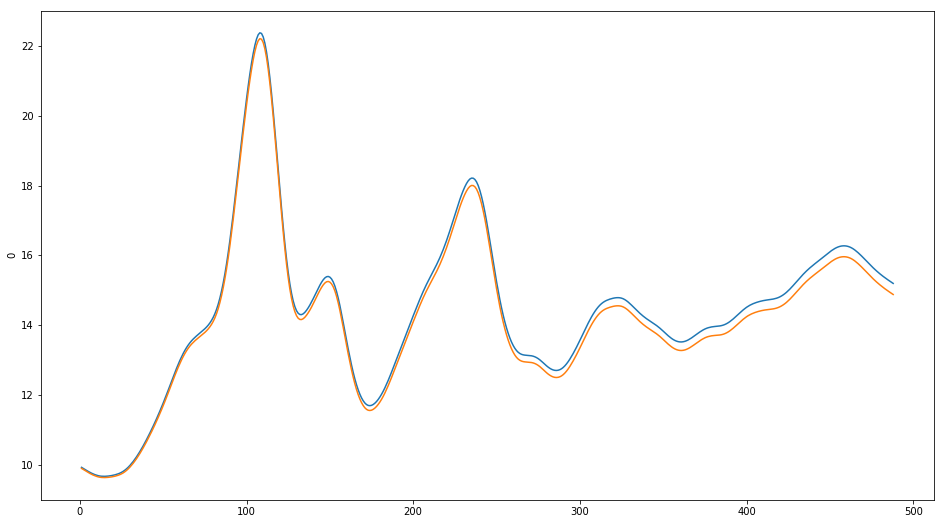

In [29]:
df = pd.DataFrame(tp,index=list(range(len(tfv)+1,len(tp)+len(tfv)+1)))
dfp = pd.DataFrame(np.append(tp,tpo),index=list(range(len(tfv)+1,len(tp)+len(tfv)+1+step)))
dfu = pd.DataFrame(np.append(tp,tpci[:,0]),index=list(range(len(tfv)+1,len(tp)+len(tfv)+1+step)))
dfd = pd.DataFrame(np.append(tp,tpci[:,1]),index=list(range(len(tfv)+1,len(tp)+len(tfv)+1+step)))
tpr = recoverDiff(df, tfv)
tppr = recoverDiff(dfp, tfv)
tpur = recoverDiff(dfu, tfv)
tpdr = recoverDiff(dfd, tfv)
plt.figure(figsize=(16,9))
sns.lineplot(x,trend)
sns.lineplot(x,tpr[0])

In [30]:
best_score,best_cfg = chooseModels2(cycles,5,method='bic')

(0, 0) 1389.2153709162344
(0, 1) 1075.8705866617404
(0, 2) error
(0, 3) 918.4695979345088
(0, 4) error
(1, 0) 866.402359403205
(1, 1) 864.4100250597903
(1, 2) 869.7266713362823
(1, 3) 875.8923826627145
(1, 4) 869.1677978497584
(2, 0) 863.5411228112164
(2, 1) 812.4692202890211
(2, 2) 818.6543006755667
(2, 3) 821.2663930238037
(2, 4) 823.6056709598388
(3, 0) 869.0027996275128
(3, 1) 818.6552737713404
(3, 2) 823.5266594353169
(3, 3) 828.8519616678823
(3, 4) 821.2537969513266
(4, 0) 873.2697039404278
(4, 1) 821.0011763720053
(4, 2) 829.2032881198581
(4, 3) 819.1717962916634
(4, 4) 822.7566863330409


In [31]:
best_score,best_cfg

(812.4692202890211, (2, 1))

True

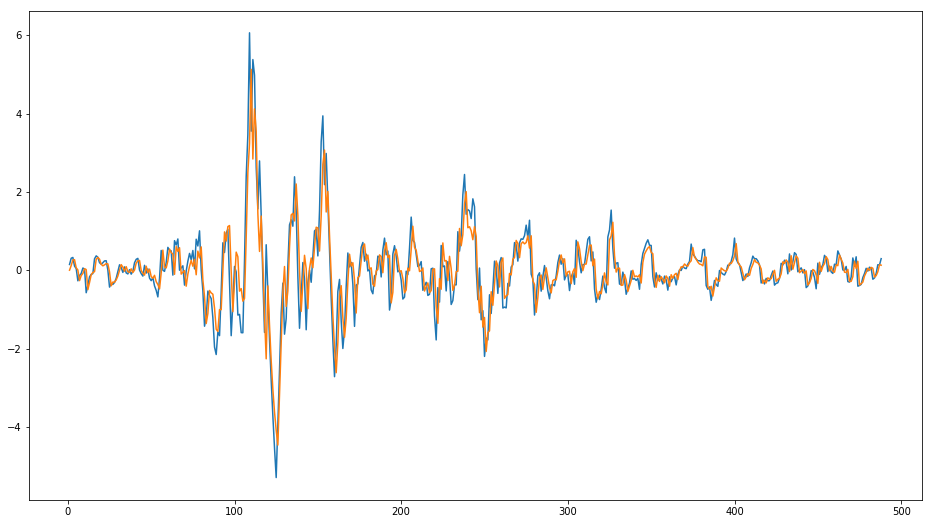

In [32]:
model, model_result = fitModel(cycles,best_cfg)
mf = modelBLQ(model_result,10)
cp = forcastInModel(model_result)
cpo,cpci = forcastOutModel(model_result,step)
plt.figure(figsize=(16,9))
sns.lineplot(x,cycles)
sns.lineplot(x,cp)
mf

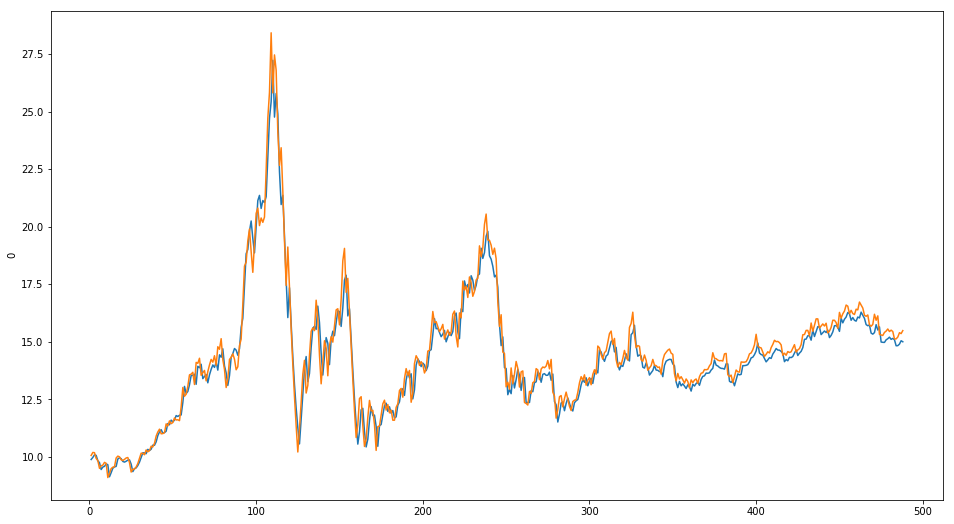

In [33]:
pdata = cp + tpr[0]
plt.figure(figsize=(16,9))
sns.lineplot(x,pdata)
sns.lineplot(x,y)

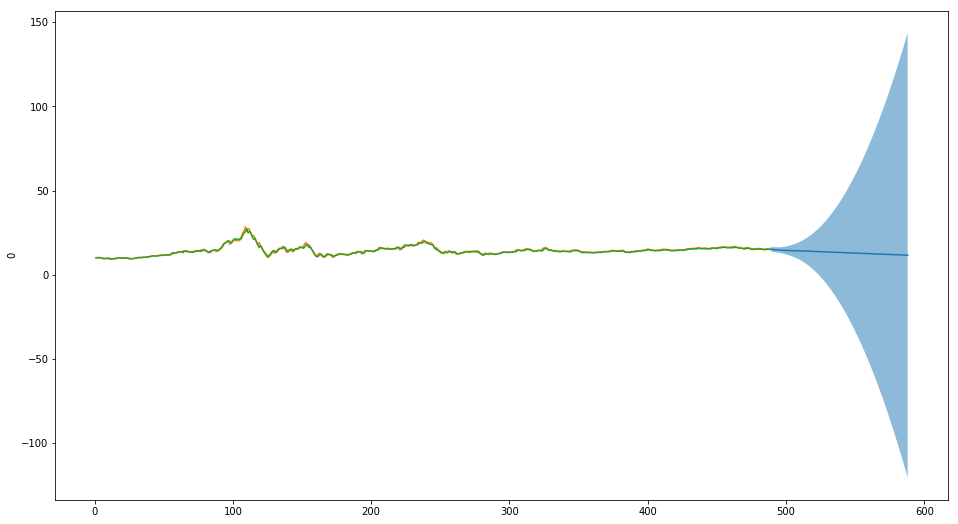

In [34]:
pdatao = cpo + tppr[0][-step:].values
plt.figure(figsize=(16,9))
sns.lineplot(list(range(489,489+step)),pdatao)
sns.lineplot(x,y)
sns.lineplot(x,pdata)
plt.fill_between(list(range(489,489+step)),cpci[:,0]+tpur[0][-step:].values,cpci[:,1]+tpdr[0][-step:].values,alpha=0.5)

## 小波分析

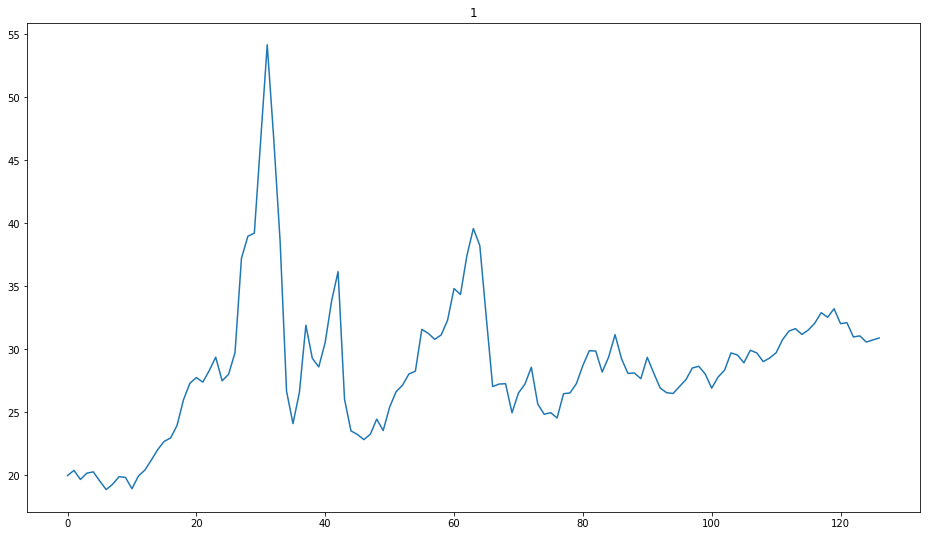

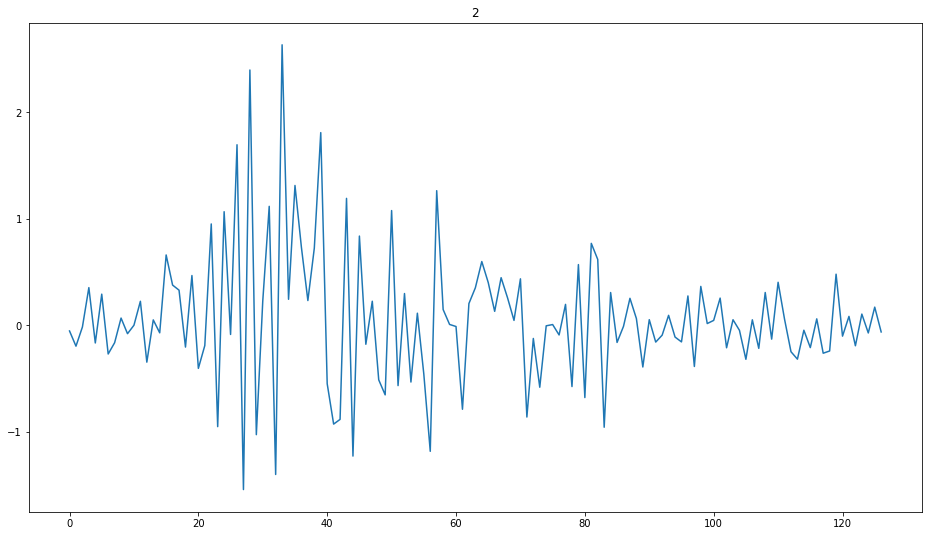

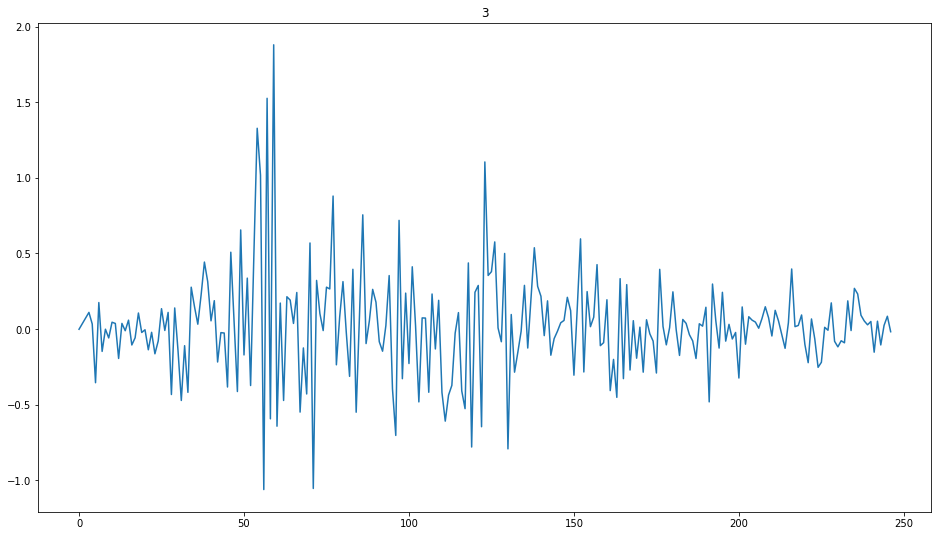

In [44]:
step = 100;
coffes = waveletFilter(y,2)    # 进行HP滤波分解
# plt.figure(figsize=(16,9))
# sns.lineplot(x,y)
coffes2 = waveletFilter(np.append(y,np.linspace(0,100,100)),2)
steps = [len(coffes2[0])-len(coffes[0]),len(coffes2[1])-len(coffes[1]),len(coffes2[2])-len(coffes[2])]
i = 1
for coffe in coffes:
    # print(coffe)
    plt.figure(figsize=(16,9))
    plt.title(i)
    sns.lineplot(list(range(len(coffe))),coffe)
    i+=1

In [45]:
steps

[25, 25, 50]

In [46]:
for coffe in coffes:
    print(adfTest(coffe))

False
True
True


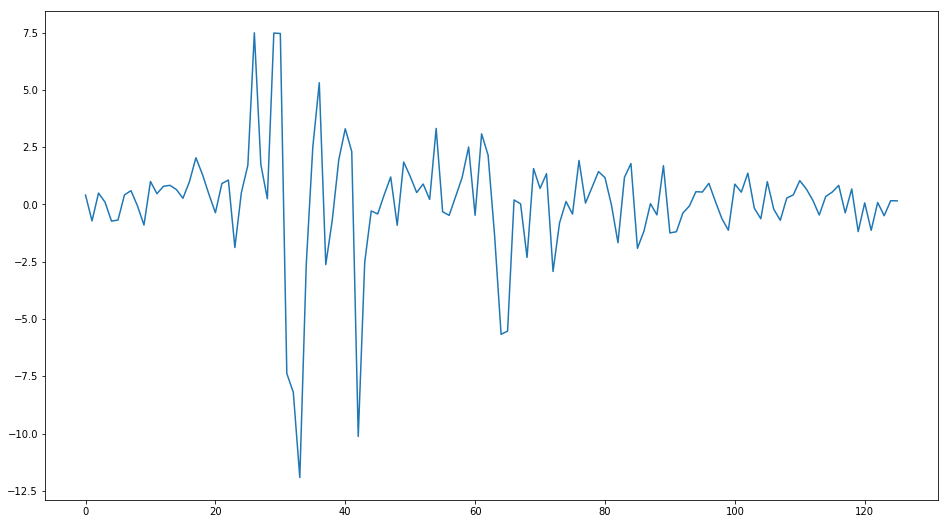

In [47]:
ad,afv = bestDiff(pd.DataFrame(coffes[0]))
ad = ad.values
plt.figure(figsize=(16,9))
sns.lineplot(list(range(len(ad))),ad)

In [48]:
best_score,best_cfg = chooseModels2(ad,5,method='bic')

(0, 0) 600.2690213370469
(0, 1) 585.4940144229992
(0, 2) 589.955112319535
(0, 3) 589.9618183905318
(0, 4) 590.2239513506528
(1, 0) 589.642559131766
(1, 1) 590.1908674016591
(1, 2) 586.4888651264454
(1, 3) 587.6532425232247
(1, 4) error
(2, 0) 586.0944469320939
(2, 1) 586.6458716253658
(2, 2) 592.4930834250305
(2, 3) 592.354181000786
(2, 4) error
(3, 0) 589.0723202526272
(3, 1) 593.6017993920834
(3, 2) 595.5905190833057
(3, 3) 595.1443197782121
(3, 4) error
(4, 0) 593.6773551342563
(4, 1) 598.4113021914732
(4, 2) 599.0435780078417
(4, 3) 595.0999120465101
(4, 4) error


In [49]:
best_score,best_cfg

(585.4940144229992, (0, 1))

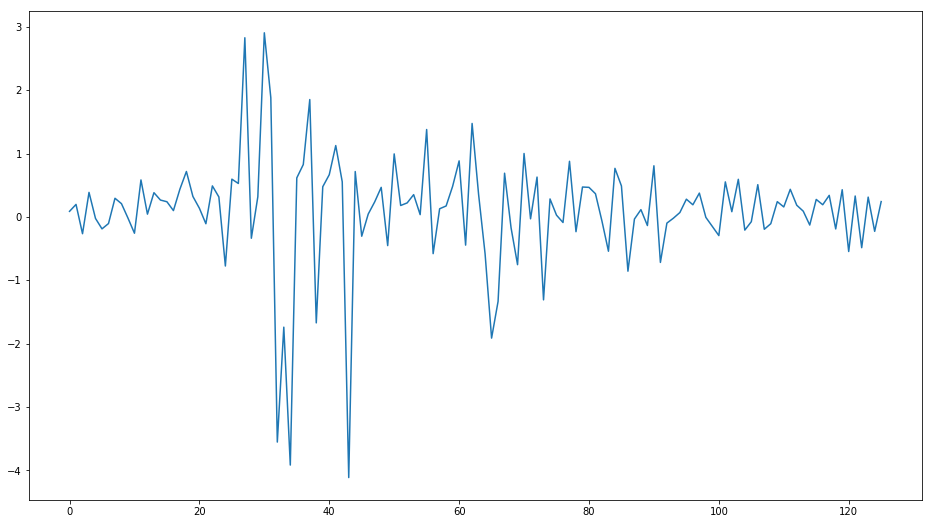

In [50]:
model, model_result = fitModel(ad,best_cfg)
ap = forcastInModel(model_result)
apo,apci = forcastOutModel(model_result,steps[0])
plt.figure(figsize=(16,9))
sns.lineplot(list(range(len(ad))),ap)

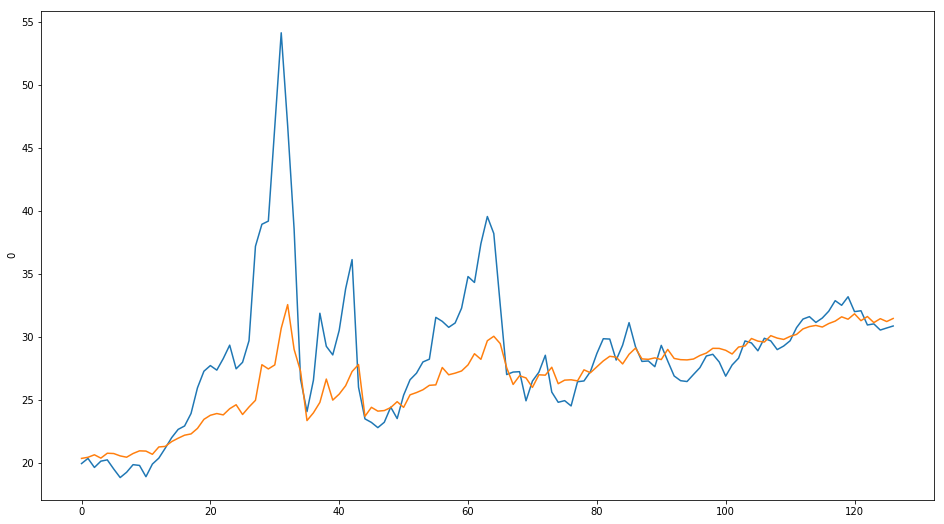

In [51]:
df = pd.DataFrame(ap,index=list(range(len(afv)+1,len(ap)+len(afv)+1)))
dfp = pd.DataFrame(np.append(ap,apo),index=list(range(len(afv)+1,len(ap)+len(afv)+1+steps[0])))
dfu = pd.DataFrame(np.append(ap,apci[:,0]),index=list(range(len(afv)+1,len(ap)+len(afv)+1+steps[0])))
dfd = pd.DataFrame(np.append(ap,apci[:,1]),index=list(range(len(afv)+1,len(ap)+len(afv)+1+steps[0])))
apr = recoverDiff(df, afv)
appr = recoverDiff(dfp, afv)
apur = recoverDiff(dfu, afv)
apdr = recoverDiff(dfd, afv)
plt.figure(figsize=(16,9))
sns.lineplot(list(range(len(coffes[0]))),coffes[0])
sns.lineplot(list(range(len(coffes[0]))),apr[0])

In [52]:
best_score,best_cfg = chooseModels2(coffes[1],5,method='bic')

(0, 0) 256.8877896759146
(0, 1) 246.60321345988416
(0, 2) 238.54681383591608
(0, 3) 242.4320592760104
(0, 4) 246.40345707547652
(1, 0) 238.75025101238737
(1, 1) 241.8895795959282
(1, 2) 242.24665212356945
(1, 3) 247.92504128502316
(1, 4) error
(2, 0) 240.23701142961139
(2, 1) 242.03960340450195
(2, 2) 246.73250065474633
(2, 3) 250.9756792940887
(2, 4) error
(3, 0) 241.1703275160015
(3, 1) 239.7856183092954
(3, 2) 243.19634824979374
(3, 3) 247.86181364202332
(3, 4) 255.96318675030494
(4, 0) 245.6051924636973
(4, 1) 243.52734764366147
(4, 2) 247.80261358413503
(4, 3) 252.6311748588194
(4, 4) 256.4190894695959


In [53]:
best_score,best_cfg

(238.54681383591608, (0, 2))

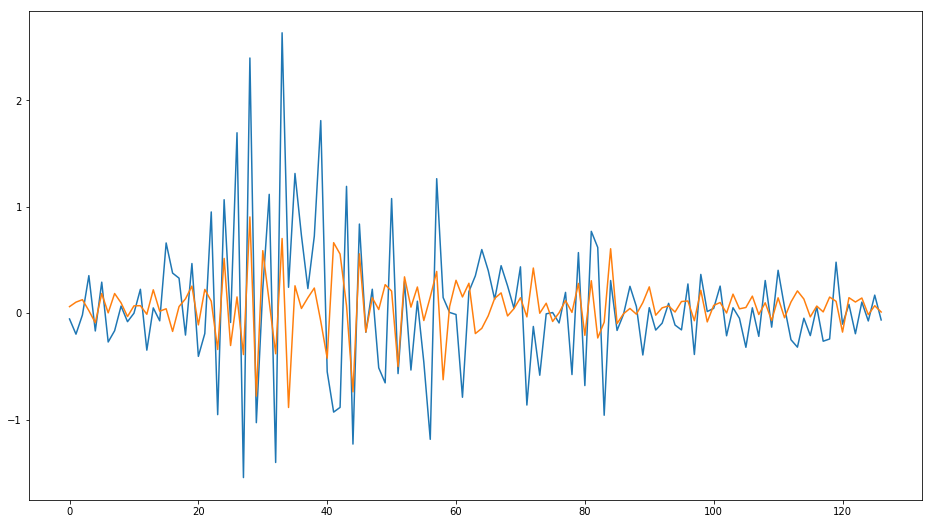

In [54]:
model, model_result = fitModel(coffes[1],best_cfg)
dp1 = forcastInModel(model_result)
dpo1,dpci1 = forcastOutModel(model_result,steps[1])
plt.figure(figsize=(16,9))
sns.lineplot(list(range(len(coffes[1]))),coffes[1])
sns.lineplot(list(range(len(dp1))),dp1)

In [55]:
best_score,best_cfg = chooseModels2(coffes[2],5,method='bic')

(0, 0) 192.80665023518415
(0, 1) 183.66824715354807
(0, 2) 172.94785550694132
(0, 3) 177.43172539946778
(0, 4) 176.220582043445
(1, 0) 177.03889527748385
(1, 1) 178.20279149496992
(1, 2) 174.233164451611
(1, 3) 183.79958962648743
(1, 4) 181.11737921199477
(2, 0) 174.96301675832774
(2, 1) 176.13645538606107
(2, 2) error
(2, 3) error
(2, 4) 183.7705592781964
(3, 0) 176.99509645067036
(3, 1) 181.04908655782322
(3, 2) 179.81491809176617
(3, 3) error
(3, 4) 188.9567476588225
(4, 0) 180.41268832291257
(4, 1) 185.8138812408177
(4, 2) 183.78146079894725
(4, 3) 189.2879747654793
(4, 4) 187.5124519252313


In [56]:
best_score,best_cfg

(172.94785550694132, (0, 2))

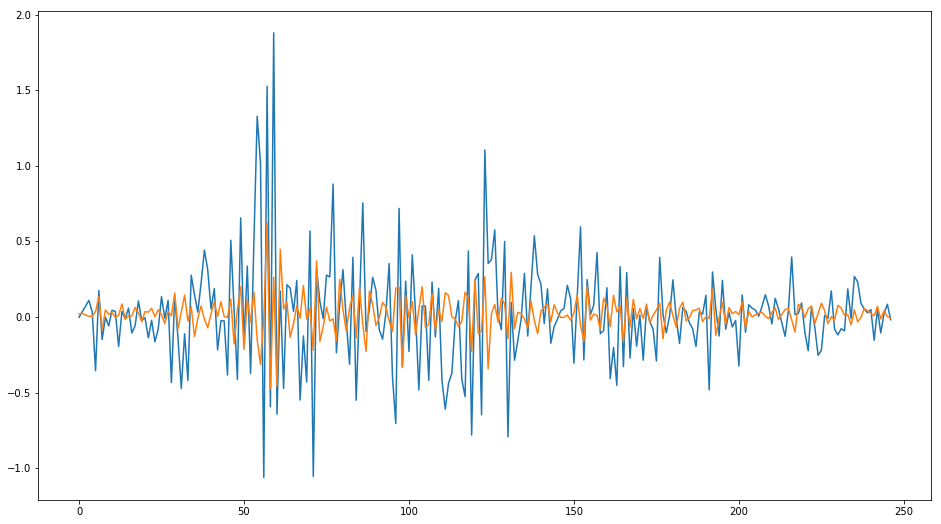

In [57]:
model, model_result = fitModel(coffes[2],best_cfg)
dp2 = forcastInModel(model_result)
dpo2,dpci2 = forcastOutModel(model_result,steps[2])
plt.figure(figsize=(16,9))
sns.lineplot(list(range(len(coffes[2]))),coffes[2])
sns.lineplot(list(range(len(dp2))),dp2)

In [58]:
coeffnewp = [np.append(apr[0],appr[0][-steps[0]:].values),np.append(dp1,dpo1),np.append(dp2,dpo2)]
coeffnewu = [np.append(apr[0],apur[0][-steps[0]:].values),np.append(dp1,dpci1[:,0]),np.append(dp2,dpci2[:,0])]
coeffnewd = [np.append(apr[0],apdr[0][-steps[0]:].values),np.append(dp1,dpci1[:,1]),np.append(dp2,dpci2[:,1])]
dcp = recoverWavelet(coeffnewp)
dcu = recoverWavelet(coeffnewu)
dcd = recoverWavelet(coeffnewd)

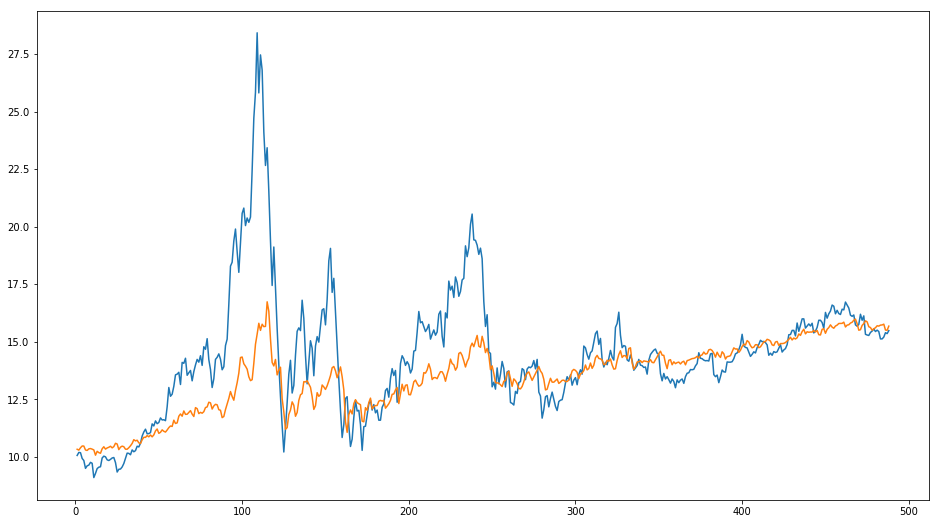

In [60]:
plt.figure(figsize=(16,9))
sns.lineplot(x,y)
sns.lineplot(x,dcp[:-100])

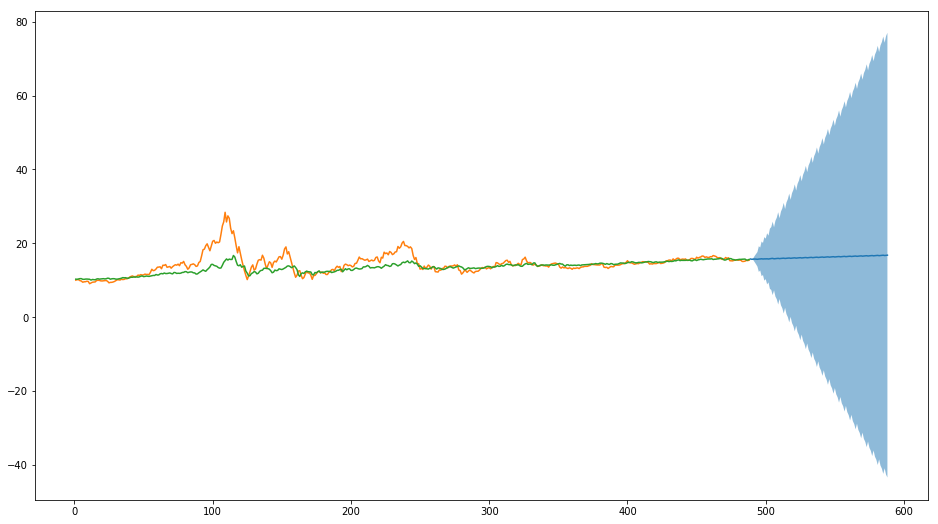

In [61]:
plt.figure(figsize=(16,9))
sns.lineplot(list(range(489,489+step)),dcp[-step:])
sns.lineplot(x,y)
sns.lineplot(x,dcp[:-step])
plt.fill_between(list(range(489,489+step)),dcu[-step:],dcd[-step:],alpha=0.5)